In [4]:
# Preparing Data

from __future__ import unicode_literals, print_function, division
from io import open
import glob # Research about glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata # research about that
import string

all_letters = string.ascii_letters + ".,;''"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s) # what is this function doing?
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusárski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding = 'utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)

['data/names/Japanese.txt', 'data/names/Dutch.txt', 'data/names/Russian.txt', 'data/names/Italian.txt', 'data/names/German.txt', 'data/names/Chinese.txt', 'data/names/Polish.txt', 'data/names/Korean.txt', 'data/names/English.txt', 'data/names/Czech.txt', 'data/names/Irish.txt', 'data/names/Greek.txt', 'data/names/Portuguese.txt', 'data/names/Arabic.txt', 'data/names/Vietnamese.txt', 'data/names/French.txt', 'data/names/Scottish.txt', 'data/names/Spanish.txt']
Slusarski


In [5]:
# Turning Names into Tensors

import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letters vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [7]:
letterToTensor('J').size()

torch.Size([1, 57])

In [8]:
# Creating the Network

import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, X, hidden):
        combined = torch.cat((X, hidden), 1) # Stack the letter tensor with the
                                             # hidden tensor.
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
    
# Isso aqui é um módulo. Como esse módulo se compara àquele disponibilizado
# pelo pytorch?
# De que modo eu faria uma rede com várias camadas?

In [20]:
n_hidden = 128 # Why the size of the hidden tensor is 128?
rnn = RNN(n_letters, n_hidden, n_categories)

# Each input/sample of the network is a letter (an instant of a time series)
X = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(X, hidden)

In [33]:
# For the sake of efficiency we don't want to be creating a new Tensor for every
# step, so we will use lineToTensor instead of letterToTensor and use slices.

X = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(X[0], hidden)
print(output)

tensor([[-2.9302, -2.9674, -2.9938, -2.9335, -2.9231, -2.8295, -2.8305, -2.8669,
         -2.8891, -2.7698, -2.9732, -2.9844, -2.8084, -2.7826, -2.9068, -2.8301,
         -2.8991, -2.9512]], grad_fn=<LogSoftmaxBackward>)


In [16]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Polish', 6)


In [17]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype = torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Irish / line = Meadhra
category = Scottish / line = Mckenzie
category = Spanish / line = Castro
category = French / line = Proulx
category = Dutch / line = Marquering
category = Russian / line = Guketlev
category = Greek / line = Papageorge
category = Czech / line = Kubin
category = Russian / line = Galkin
category = Scottish / line = Kennedy


In [18]:
# Training the Network

criterion = nn.NLLLoss() # what is this loss function?

# Each loop of training will:
# - Create input and target tensors
# - Create a zeroed initial hidden state
# - Read each letter in and
#  - Keep hidden state for next letter
# - Compare final output to target
# - Back-propagate
# - Return the output and loss

In [35]:
next(iter(rnn.parameters())).grad

In [39]:
learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
        
    return output, loss.item()

import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for i in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    if i % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (i, i / n_iters * 100, timeSince(start), loss, line, guess, correct))
        
    
    # Add current loss avg to list of losses
    if i % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 14s) 0.7265 Hadad / Arabic ✓
10000 10% (0m 26s) 3.6376 Hay / Chinese ✗ (Scottish)
15000 15% (0m 39s) 1.4952 Paszek / Polish ✓
20000 20% (0m 50s) 0.8899 Xie / Chinese ✓
25000 25% (1m 0s) 1.8574 Mogilnitsky / Polish ✗ (Russian)
30000 30% (1m 10s) 1.5885 Rios / Greek ✗ (Portuguese)
35000 35% (1m 20s) 0.7044 Wegner / German ✓
40000 40% (1m 32s) 2.4865 Kaiser / Arabic ✗ (Czech)
45000 45% (1m 44s) 1.0960 Ahn / Chinese ✗ (Korean)
50000 50% (1m 53s) 2.8350 Sappe / French ✗ (Czech)
55000 55% (2m 3s) 0.5551 Kwang / Korean ✓
60000 60% (2m 13s) 2.6964 Baroch / German ✗ (Czech)
65000 65% (2m 23s) 7.3323 Yano / Korean ✗ (Japanese)
70000 70% (2m 33s) 0.2201 Slazak / Polish ✓
75000 75% (2m 42s) 0.7934 Seok / Korean ✓
80000 80% (2m 52s) 2.7170 Alst / French ✗ (Dutch)
85000 85% (3m 2s) 0.6262 Yep / Chinese ✓
90000 90% (3m 11s) 2.1678 Guidi / Japanese ✗ (Italian)
95000 95% (3m 21s) 0.0544 Quach / Vietnamese ✓
100000 100% (3m 31s) 0.6983 Auttenberg / Polish ✓


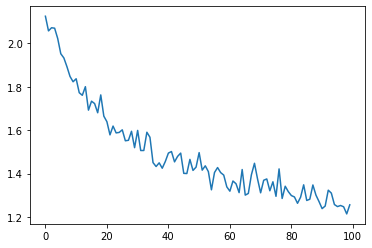

In [40]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

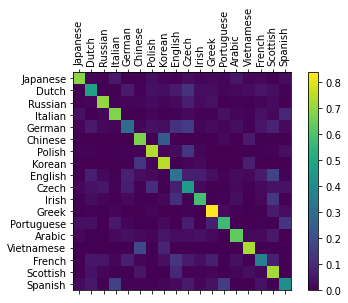

In [41]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1
    
# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation = 90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()